In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from collections import Counter

# **Utility functions**

In [2]:
def compute_m_t(element,bids):
  temp = bids.copy()
  temp.remove(element)
  temp.sort()
  return temp[-1]

In [3]:
def compute_weights(rho, rewards, costs):
  l = len(rewards)
  c = (-rewards).tolist() # declare coefficients of the objective function
  A_in = [costs.tolist()] # declare the inequality constraint matrix
  b_in = [rho] # declare the inequality constraint vector
  A_e = [np.ones(l)] # declare the equality constraint matrix
  b_e = [1] # declare the equality constraint vector
  results = linprog(c=c, A_ub=A_in, b_ub=b_in, A_eq=A_e, b_eq=b_e, method='highs-ds')   # solve
  return results.x

In [4]:
def extract(pos, lst):
    return [item[pos] for item in lst]

# **Auction**

In [5]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [6]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        #payment = values[winners]/self.ctrs[winners]
        return payment

# **Multiplicative Pacing (Primal Dual for Truthful Auctions)**

In [7]:
class MultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0

        con_bid = self.valuation/(self.lmbd+1) # Scaled continuos bid
        #return con_bid

        #Discrete bid: since other regret minimizers have discrete set of bid, we impose this also to MPAgent by choosing the closest bid
        return min(self.bids_set, key=lambda x:abs(x-con_bid))


    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        #Update the lambda
        self.budget -= c_t

# **Generalized Multiplicative Pacing (Primal Dual for Non-Truthful Auctions)**

In [8]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)

In [9]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# **UCB-like Agent**

In [10]:
class UCB1Agent:
    def __init__(self, bids_set,valuation, budget, T, range=1):

        self.bids_set = bids_set
        self.K = len(bids_set)
        self.T = T
        self.range = range

        self.a_t = None
        self.average_rewards = np.zeros(self.K)
        self.average_costs = np.zeros(self.K)
        self.N_pulls = np.zeros(self.K)
        self.t = 0

        self.budget = budget
        self.valuation = valuation
        self.rho = self.budget/self.T

    def bid(self):
      if self.budget < 1:
            return 0
      else:
        if self.t < self.K:
            self.a_t = (self.t) / (self.K-1) #rescaled bid
        else:
            ucbs_rewards = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t
            ucbs_costs = self.average_costs - self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t

            weights = compute_weights(self.rho, ucbs_rewards, ucbs_costs)
            self.a_t = np.random.choice(np.arange(self.K), p=weights) / (self.K-1)

            #self.a_t = np.argmax(ucbs_rewards) / self.K
        return self.a_t

    def update(self, r_t, c_t):
        index = int(self.a_t*(self.K-1))

        self.N_pulls[index] += 1
        self.average_rewards[index] += (r_t - self.average_rewards[index])/self.N_pulls[index]
        self.average_costs[index] += (c_t - self.average_costs[index])/self.N_pulls[index]

        self.t += 1
        self.budget -= c_t

# **Competition between algorithms step by step**

## Parameters

In [11]:
player_types_name = ["MP Agent", "FFMP Agent", "UCB Agent"]
player_types = len(player_types_name)

n_player_per_type = 1 #change this to increase competition! ---> try 1, 2, 3

n_advertisers = player_types * n_player_per_type

ctrs = np.ones(n_advertisers)
my_valuation = 0.8
B = 300
n_users = 5000

eta = 1/np.sqrt(n_users)

n_arms = 11 #change this to increse/decrese the number of arms ---> try 5, 11, 20
available_bids = np.linspace(0,1,n_arms)

## Interaction

In [12]:
players = []

#initialize players and auction
for i in range(n_player_per_type):
  MP_Agent = MultiplicativePacingAgent(bids_set=available_bids, valuation=my_valuation, budget=B, T=n_users, eta=eta)
  FFMP_Agent = FFMultiplicativePacingAgent(bids_set=available_bids, valuation=my_valuation, budget=B, T=n_users, eta=eta)
  UCB1_Agent = UCB1Agent(bids_set=available_bids,valuation=my_valuation, budget=B, T=n_users)

  players.append(MP_Agent)
  players.append(FFMP_Agent)
  players.append(UCB1_Agent)

auction = FirstPriceAuction(np.ones(n_advertisers))

#initialize arrays for logging
utilities_array = [[] for _ in range(n_advertisers)]
bids_array = [[] for _ in range(n_advertisers)]
payments_array = [[] for _ in range(n_advertisers)]
winner_history = []
total_wins_array = [0] * n_advertisers

#array for checking if everyone has depleted his budget
#if players[i] has depleted his budget -> budgets_flag[i] = 1
budgets_flag = [0] * n_advertisers

np.random.seed(18)

#start interaction
for u in range(n_users):
    bids = []

    #player select their bid
    for i in range(n_advertisers):
      bid = players[i].bid()
      bids.append(bid)
      bids = [round(elem, 2) for elem in bids] #formatted: round bids up to 2 decimal numbers
      #logging bids
      bids_array[i].append(bid)

    #check who is the winner
    winners, payments_per_click = auction.round(bids=bids)
    winner = [0] * n_advertisers
    winner[winners] = 1
    winner_history.append(winner)

    #update players and log
    for j in range(n_advertisers):
      f_t, c_t = (my_valuation-payments_per_click)*winner[j], payments_per_click*winner[j]

      if isinstance(players[j], FFMultiplicativePacingAgent):
        m_t = compute_m_t(bids[j], bids)
        players[j].update(f_t, c_t, m_t)
      else:
        players[j].update(f_t, c_t)

      #check if players have depleted their budget
      if players[j].budget < 1:
        budgets_flag[j] = 1

      # logging
      utilities_array[j].append(f_t)
      payments_array[j].append(c_t)
      total_wins_array[j] += winner[j]

    #print the round
    #print(f'Round {u}) --- Bids: {bids} --- Winner: {player_types_name[winners%3]} {int(i/3) + 1} --- payment: {payments_per_click}')

    # Check if everyone is out of budget: if yes -> stop the rounds
    flag = 1
    for i in budgets_flag:
      flag = flag*i
    if flag == 1:
      break

#Print some results
print(f'Total # of interactions: {u}')
for i in range(n_advertisers):
  print(f'Total # of Wins of player {player_types_name[i%3]} {int(i/3) + 1}: {total_wins_array[i]}')

Total # of interactions: 2143
Total # of Wins of player MP Agent 1: 1132
Total # of Wins of player FFMP Agent 1: 500
Total # of Wins of player UCB Agent 1: 512


## Plots

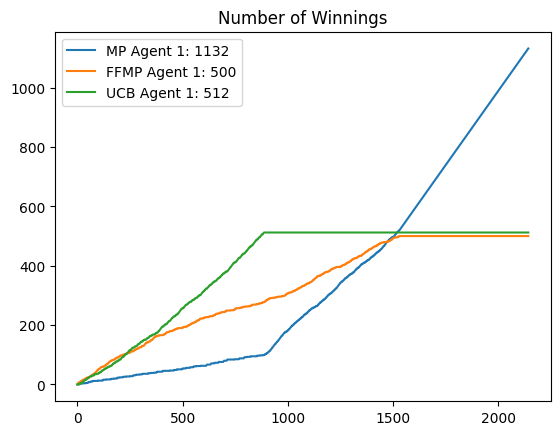

In [13]:
for i in range(n_advertisers):
  plt.plot(np.array(extract(i,winner_history)).cumsum(), label=f'{player_types_name[i%3]} {int(i/3) + 1}: {total_wins_array[i]}')
  plt.title('Number of Winnings')
plt.legend()
plt.show()

"\nfor i in range(n_advertisers):\n  plt.plot(bids_array[i], label=f'{player_types_name[i%3] {int(i/3) + 1}}')\nplt.legend()\nplt.show()\n"

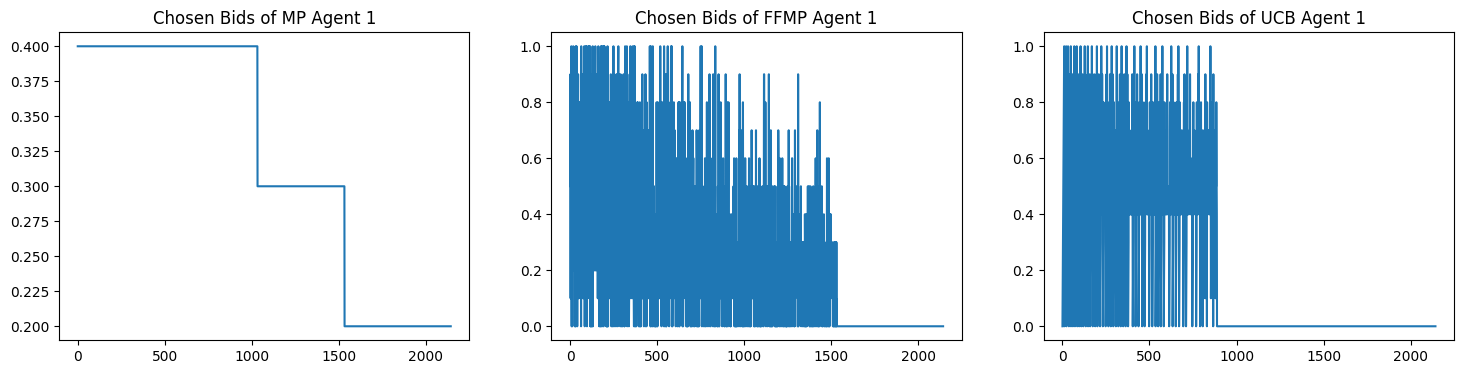

In [14]:
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))

for i in range(n_advertisers):
  axes[i].plot(bids_array[i])
  axes[i].set_title(f'Chosen Bids of {player_types_name[i%3]} {int(i/3) + 1}')

'''
for i in range(n_advertisers):
  plt.plot(bids_array[i], label=f'{player_types_name[i%3] {int(i/3) + 1}}')
plt.legend()
plt.show()
'''

"\nfor i in range(n_advertisers):\n  #data = bids_array[i]\n  data = [ elem for elem in bids_array[i] if elem != 0] #dropped bids=0 (no bid)\n\n  data_keys = Counter(data).keys() # equals to list(set(words))\n  data_values = Counter(data).values()\n\n  plt.bar(data_keys,data_values,edgecolor='black', width=i*0.05, label=f'{player_types_name[i%3]}')\n\nplt.legend()\nplt.show()\n"

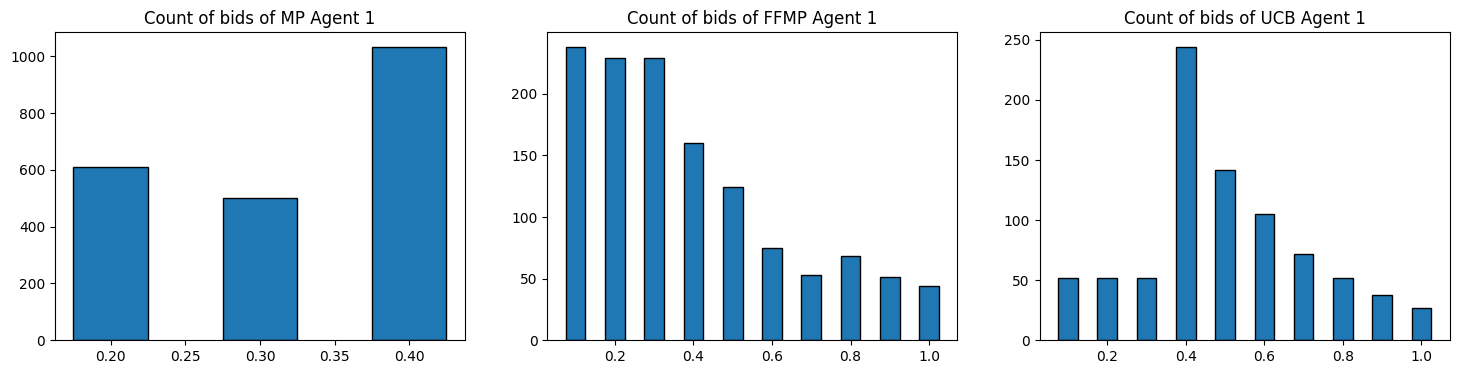

In [15]:
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))
for i in range(n_advertisers):
  #data = bids_array[i]
  data = [elem for elem in bids_array[i] if elem != 0] #drop bids=0 (no bid)

  data_keys = Counter(data).keys()
  data_values = Counter(data).values()

  axes[i].bar(data_keys,data_values,edgecolor='black',width=0.05)
  axes[i].set_title(f'Count of bids of {player_types_name[i%3]} {int(i/3) + 1}')

'''
for i in range(n_advertisers):
  #data = bids_array[i]
  data = [ elem for elem in bids_array[i] if elem != 0] #dropped bids=0 (no bid)

  data_keys = Counter(data).keys() # equals to list(set(words))
  data_values = Counter(data).values()

  plt.bar(data_keys,data_values,edgecolor='black', width=i*0.05, label=f'{player_types_name[i%3]}')

plt.legend()
plt.show()
'''

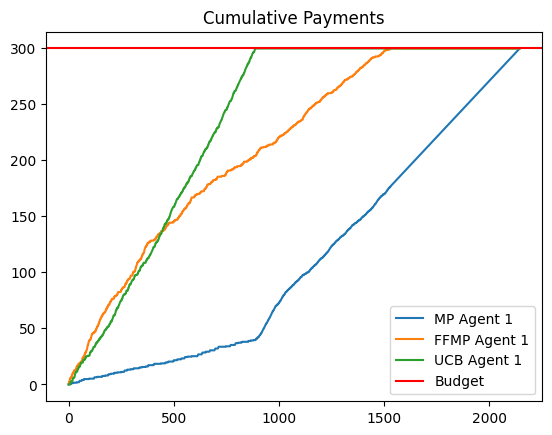

In [16]:
'''
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))

for i in range(n_advertisers):
  cumulative_payments = np.cumsum(payments_array[i])
  axes[i].plot(cumulative_payments)
  axes[i].axhline(B, color='red', label='Budget')
  axes[i].set_title(f'Cumulative payments of {player_types_name[i%3]} {int(i/3) + 1}')
'''

for i in range(n_advertisers):
  cumulative_payments = np.cumsum(payments_array[i])
  plt.plot(cumulative_payments,label=f'{player_types_name[i%3]} {int(i/3) + 1}')
  plt.title('Cumulative Payments')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.show()

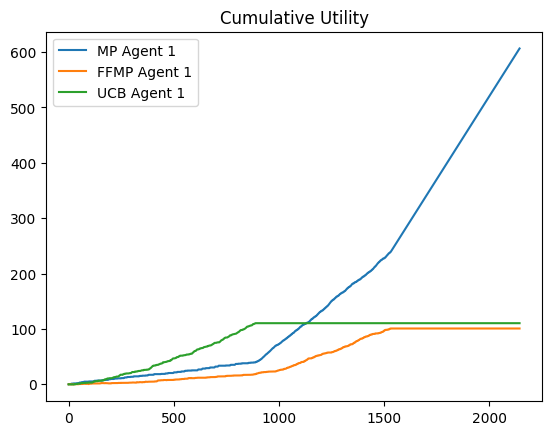

In [17]:
'''
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))

for i in range(n_advertisers):
  cumulative_utilities = np.cumsum(utilities_array[i])
  axes[i].plot(cumulative_utilities)
  axes[i].set_title(f'Cumulative utility of {player_types_name[i%3]} {int(i/3) + 1}')
'''

for i in range(n_advertisers):
  cumulative_utilities = np.cumsum(utilities_array[i])
  plt.plot(cumulative_utilities,label=f'{player_types_name[i%3]} {int(i/3) + 1}')
  plt.title('Cumulative Utility')

plt.legend()
plt.show()

# **Try different Parameters**

## Class Trial

In [18]:
player_types_name = ["MP Agent", "FFMP Agent", "UCB Agent"]
player_types = len(player_types_name)

class Trial:
  def __init__(self, n_player_per_type=1, my_valuation=0.8, B=300, n_users=5000, n_arms=11):

    self.player_types_name = ["MP Agent", "FFMP Agent", "UCB Agent"]
    self.player_types = len(player_types_name)

    self.n_player_per_type = n_player_per_type
    self.my_valuation = my_valuation
    self.B = B
    self.n_users = n_users
    self.n_arms = n_arms

    self.n_advertisers = player_types * n_player_per_type

    self.ctrs = np.ones(n_advertisers)
    self.eta = 1/np.sqrt(n_users)
    self.available_bids = np.linspace(0,1,n_arms)

    self.players = []

    #initialize players and auction
    for i in range(self.n_player_per_type):
      MP_Agent = MultiplicativePacingAgent(bids_set=self.available_bids, valuation=self.my_valuation, budget=self.B, T=self.n_users, eta=self.eta)
      FFMP_Agent = FFMultiplicativePacingAgent(bids_set=self.available_bids, valuation=self.my_valuation, budget=self.B, T=self.n_users, eta=self.eta)
      UCB1_Agent = UCB1Agent(bids_set=self.available_bids, valuation=self.my_valuation, budget=self.B, T=self.n_users)

      self.players.append(MP_Agent)
      self.players.append(FFMP_Agent)
      self.players.append(UCB1_Agent)

    self.auction = FirstPriceAuction(np.ones(self.n_advertisers))

    #initialize arrays for logging
    self.utilities_array = [[] for _ in range(self.n_advertisers)]
    self.bids_array = [[] for _ in range(self.n_advertisers)]
    self.payments_array = [[] for _ in range(self.n_advertisers)]
    self.winner_history = []
    self.total_wins_array = [0] * self.n_advertisers

    #array for checking if everyone has depleted his budget
    #if players[i] has depleted his budget -> budgets_flag[i] = 1
    self.budgets_flag = [0] * self.n_advertisers

    np.random.seed(18)

    #start interaction
    for u in range(self.n_users):
        bids = []

        #player select their bid
        for i in range(self.n_advertisers):
          bid = self.players[i].bid()
          bids.append(bid)
          bids = [round(elem, 2) for elem in bids] #formatted: round bids up to 2 decimal numbers
          #logging bids
          self.bids_array[i].append(bid)

        #check who is the winner
        winners, payments_per_click = self.auction.round(bids=bids)
        winner = [0] * self.n_advertisers
        winner[winners] = 1
        self.winner_history.append(winner)

        #update players and log
        for j in range(self.n_advertisers):
          f_t, c_t = (self.my_valuation-payments_per_click)*winner[j], payments_per_click*winner[j]

          if isinstance(self.players[j], FFMultiplicativePacingAgent):
            m_t = compute_m_t(bids[j], bids)
            self.players[j].update(f_t, c_t, m_t)
          else:
            self.players[j].update(f_t, c_t)

          #check if players have depleted their budget
          if self.players[j].budget < 1:
            self.budgets_flag[j] = 1

          # logging
          self.utilities_array[j].append(f_t)
          self.payments_array[j].append(c_t)
          self.total_wins_array[j] += winner[j]

        #print the round
        #print(f'Round {u}) --- Bids: {bids} --- Winner: {player_types_name[winners%3]} --- payment: {payments_per_click}')

        # Check if everyone is out of budget: if yes -> stop the rounds
        flag = 1
        for i in self.budgets_flag:
          flag = flag*i
        if flag == 1:
          break

    #Print some results
    print(f'Total # of interactions: {u}')
    for i in range(self.n_advertisers):
      print(f'Total # of Wins of player {self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_wins_array[i]}')

    #Draw winnings, payments and utilities
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4))
    for i in range(self.n_advertisers):
      axes[0].plot(np.array(extract(i,self.winner_history)).cumsum(), label=f'{self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_wins_array[i]}')

      cumulative_payments = np.cumsum(self.payments_array[i])
      axes[1].plot(cumulative_payments,label=f'{self.player_types_name[i%3]} {int(i/3) + 1}')

      cumulative_utilities = np.cumsum(self.utilities_array[i])
      axes[2].plot(cumulative_utilities,label=f'{self.player_types_name[i%3]} {int(i/3) + 1}')

    axes[1].axhline(B, color='red', label='Budget')

    axes[0].set_title('Number of Winnings')
    axes[0].legend()
    axes[1].set_title('Cumulative Payments')
    axes[1].legend()
    axes[2].set_title('Cumulative Utility')
    axes[2].legend()

    #Draw chosen bids
    fig, axes = plt.subplots(nrows=self.n_player_per_type, ncols=self.player_types, figsize = (self.player_types*6,self.n_player_per_type*4))
    axes = axes.reshape((-1,))
    for i in range(self.n_advertisers):
      axes[i].plot(self.bids_array[i])
      axes[i].set_title(f'Chosen Bids of {self.player_types_name[i%3]} {int(i/3) + 1}')

    #Draw count of bids
    fig, axes = plt.subplots(nrows=self.n_player_per_type, ncols=self.player_types, figsize = (self.player_types*6,self.n_player_per_type*4))
    axes = axes.reshape((-1,))
    for i in range(self.n_advertisers):
      #data = bids_array[i]
      data = [elem for elem in self.bids_array[i] if elem != 0] #drop bids=0 (no bid)
      data_keys = Counter(data).keys()
      data_values = Counter(data).values()
      axes[i].bar(data_keys,data_values,edgecolor='black',width=0.05)
      axes[i].set_title(f'Count of bids of {self.player_types_name[i%3]} {int(i/3) + 1}')

## First test: as first trial (default trial)


*   n_player_per_type = 1
*   my_evaluation = 0.8
*   B = 300
*   n_users = 5000
*   n_arms = 11



Total # of interactions: 2143
Total # of Wins of player MP Agent 1: 1132
Total # of Wins of player FFMP Agent 1: 500
Total # of Wins of player UCB Agent 1: 512


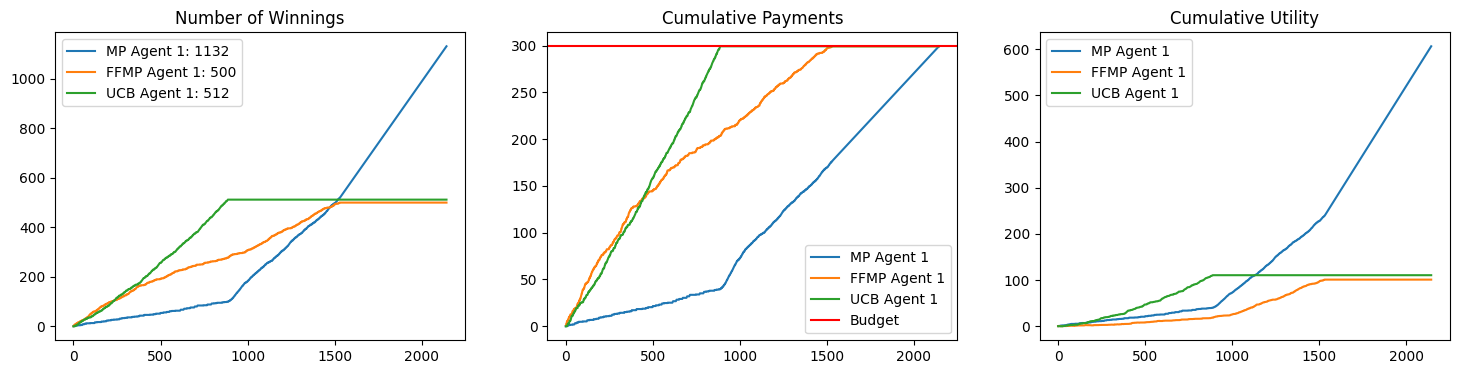

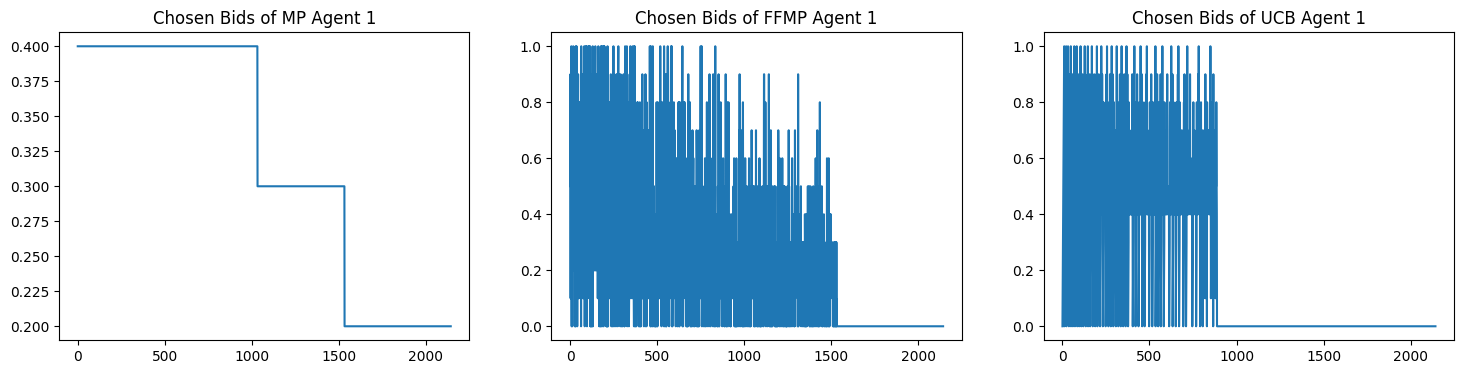

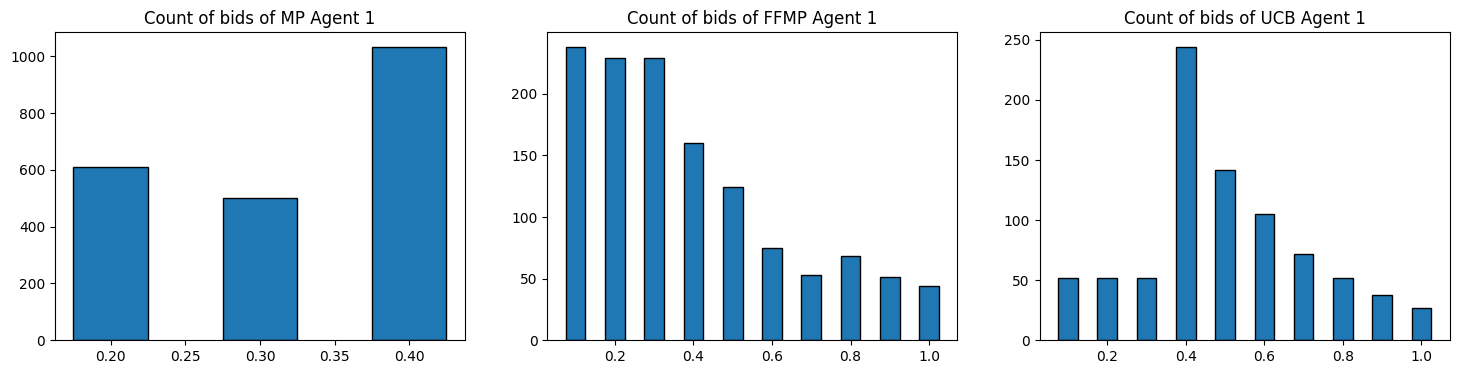

In [19]:
trial = Trial()

## Increase competition (player_per_type = 3)

*   **n_player_per_type = 3**
*   my_evaluation = 0.8
*   B = 300
*   n_users = 5000
*   n_arms = 11

Total # of interactions: 4341
Total # of Wins of player MP Agent 1: 609
Total # of Wins of player FFMP Agent 1: 437
Total # of Wins of player UCB Agent 1: 360
Total # of Wins of player MP Agent 2: 636
Total # of Wins of player FFMP Agent 2: 444
Total # of Wins of player UCB Agent 2: 362
Total # of Wins of player MP Agent 3: 683
Total # of Wins of player FFMP Agent 3: 444
Total # of Wins of player UCB Agent 3: 367


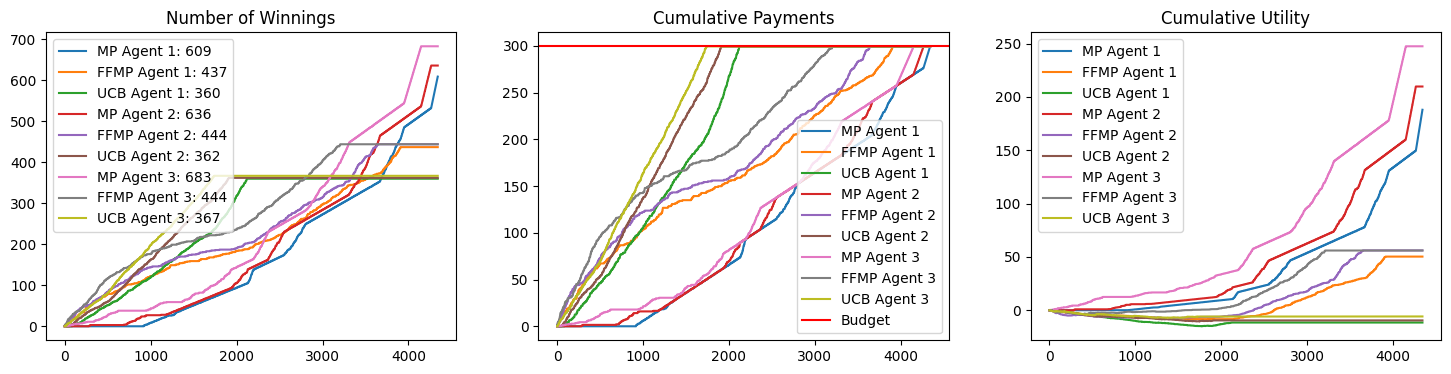

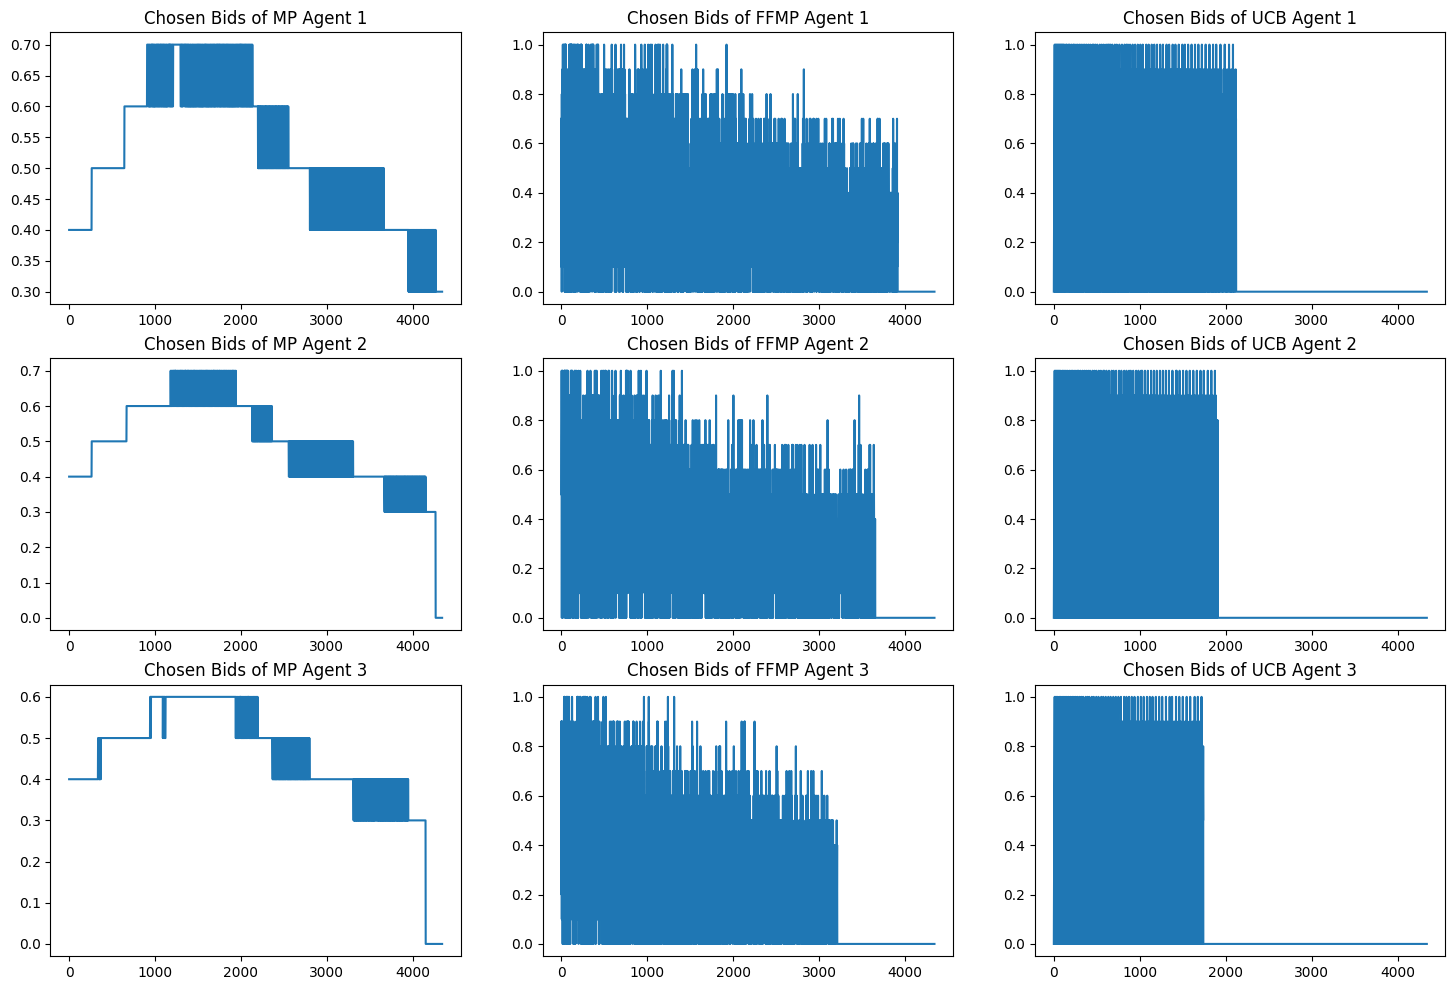

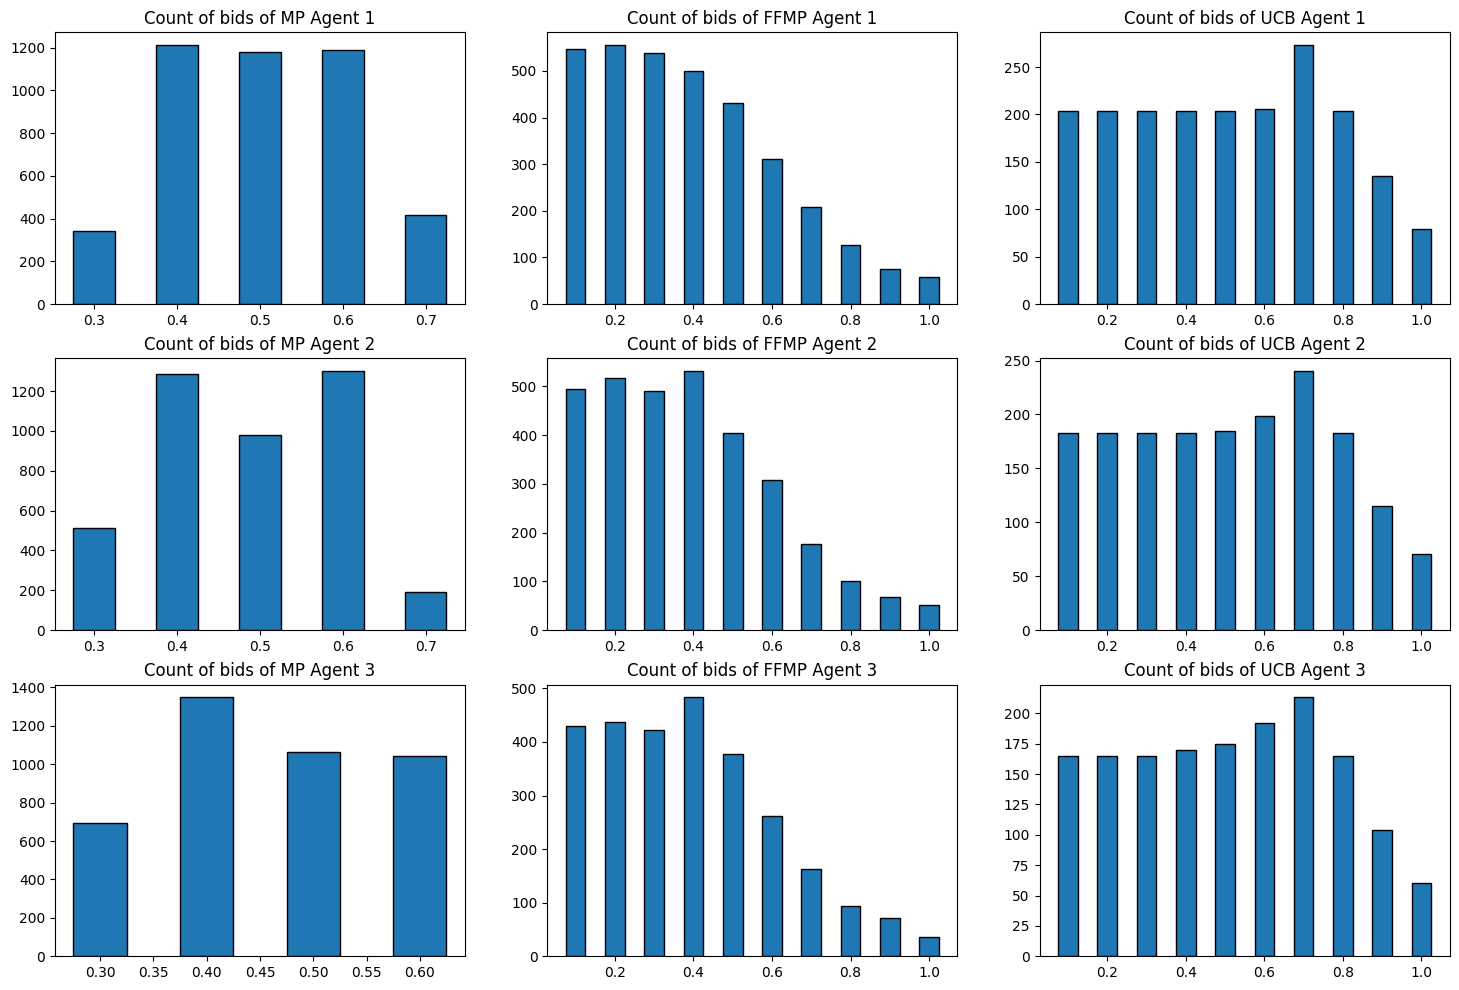

In [20]:
trial = Trial(n_player_per_type=3)

## Increase budget (B = 1000)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   **B = 1000**
*   n_users = 5000
*   n_arms = 11

Total # of interactions: 4999
Total # of Wins of player MP Agent 1: 2078
Total # of Wins of player FFMP Agent 1: 1401
Total # of Wins of player UCB Agent 1: 1521


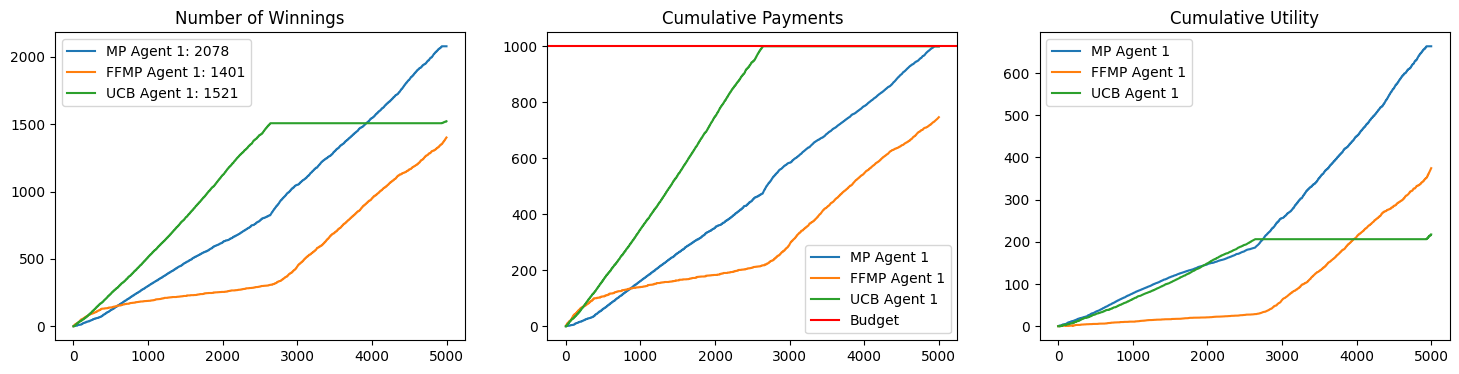

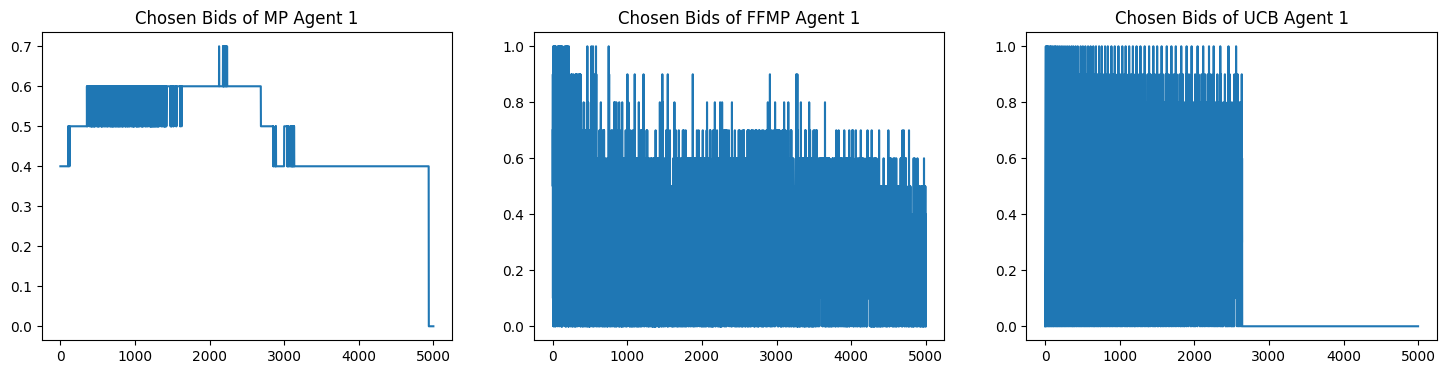

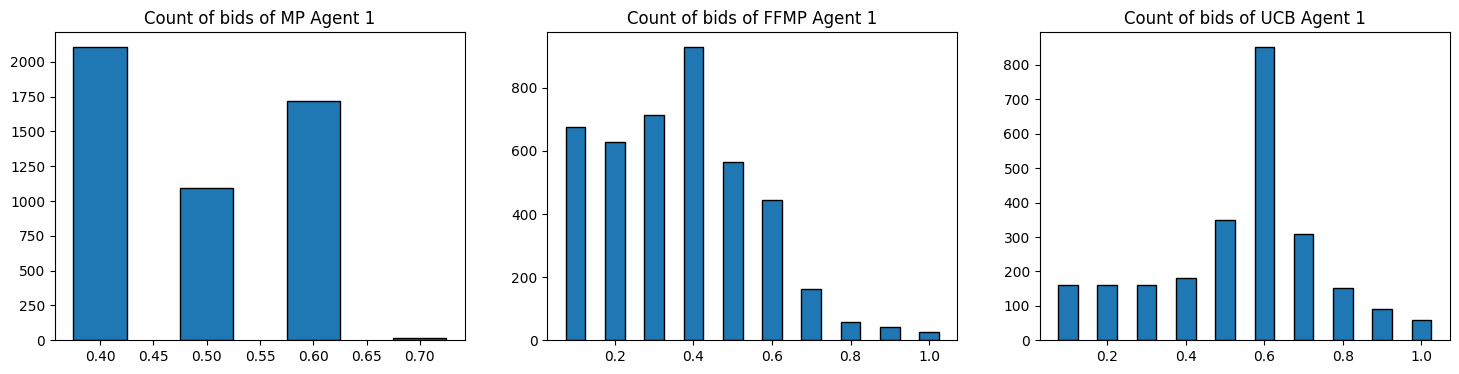

In [21]:
trial=Trial(B=1000)

## Decrease budget (B = 100)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   **B = 100**
*   n_users = 5000
*   n_arms = 11

Total # of interactions: 589
Total # of Wins of player MP Agent 1: 312
Total # of Wins of player FFMP Agent 1: 130
Total # of Wins of player UCB Agent 1: 148


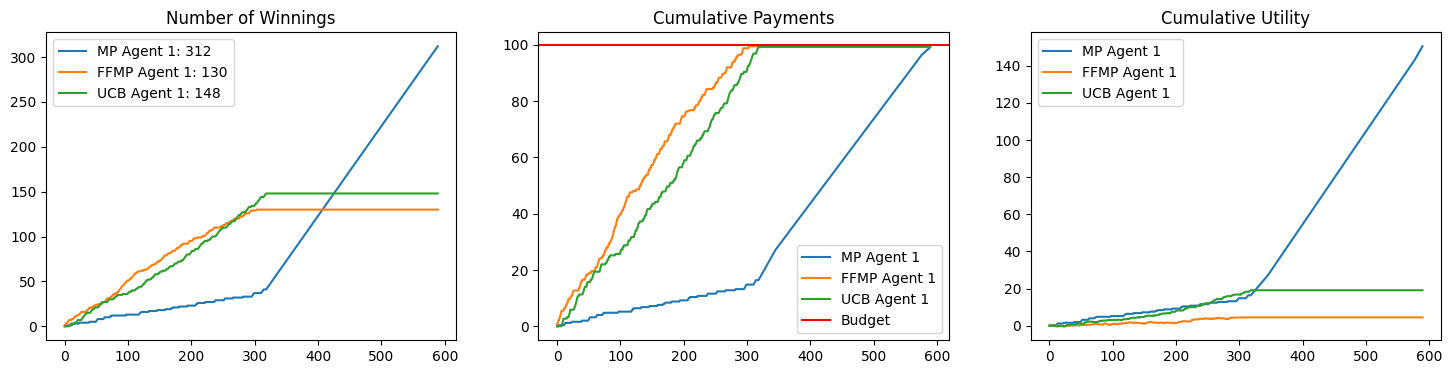

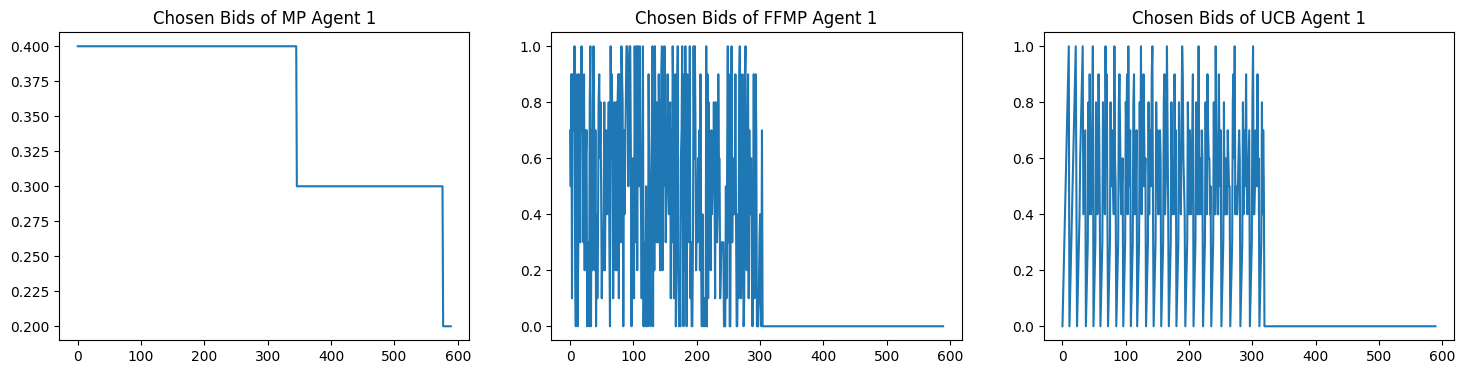

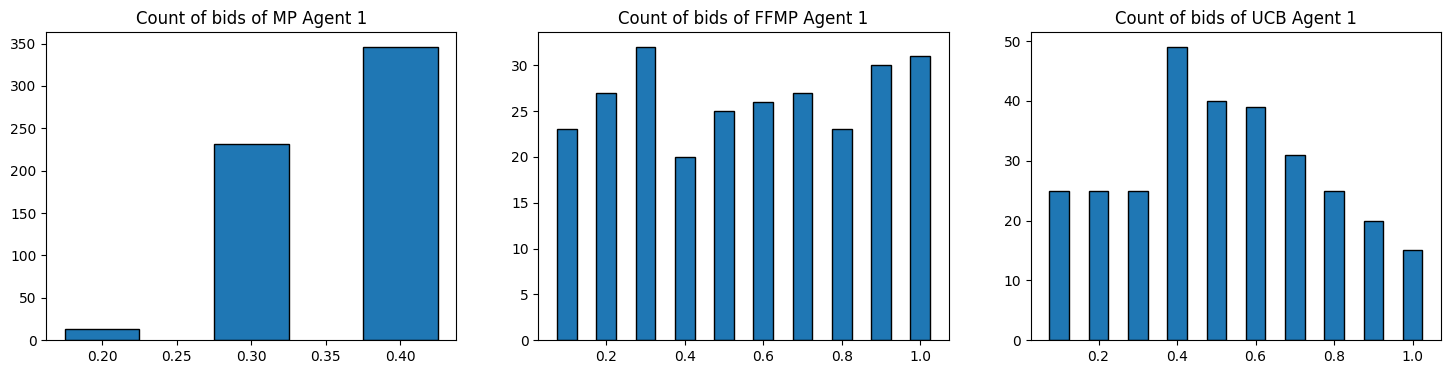

In [22]:
trial=Trial(B=100)

## Increase number of users i.e. rounds (n_users = 10000)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   B = 100
*   **n_users = 10000**
*   n_arms = 11

Total # of interactions: 2073
Total # of Wins of player MP Agent 1: 1175
Total # of Wins of player FFMP Agent 1: 411
Total # of Wins of player UCB Agent 1: 488


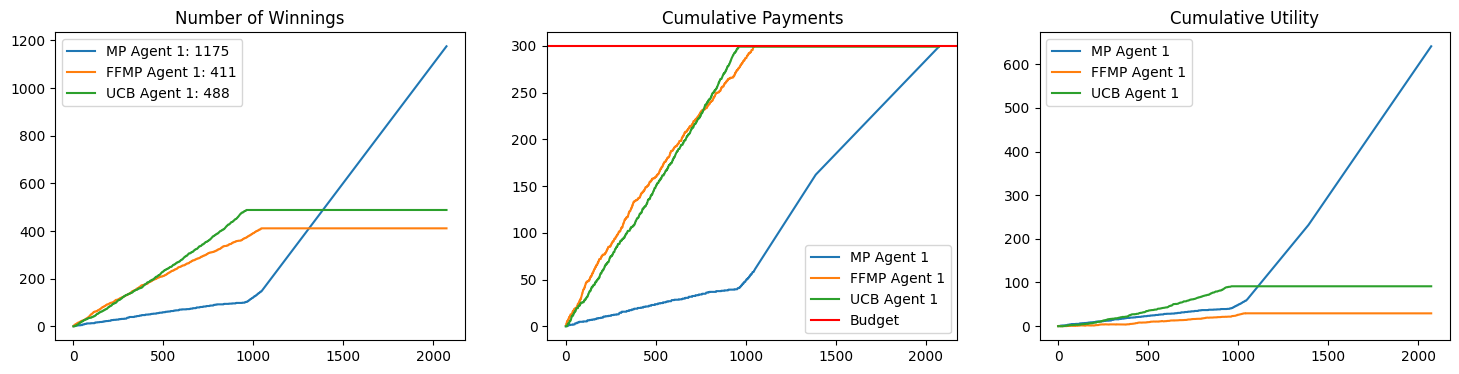

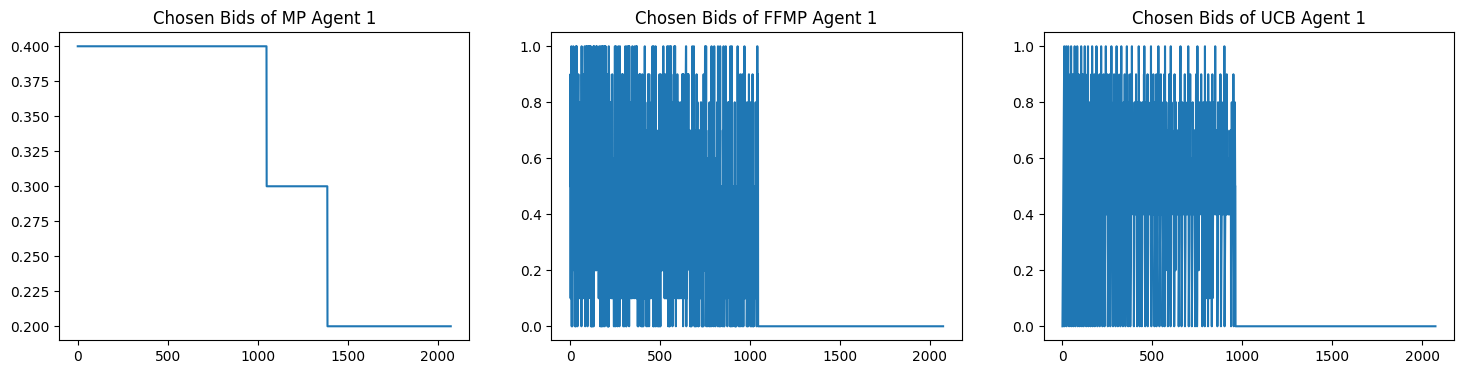

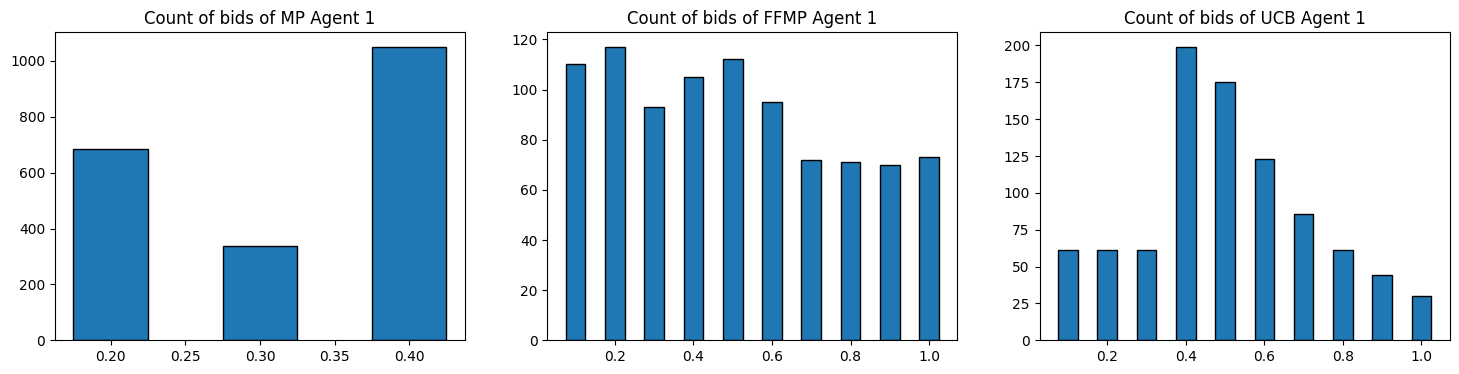

In [23]:
trial=Trial(n_users=10000)

## Decrease number of users i.e. rounds (n_users = 1000)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   B = 300
*   **n_users = 1000**
*   n_arms = 11

Total # of interactions: 999
Total # of Wins of player MP Agent 1: 451
Total # of Wins of player FFMP Agent 1: 147
Total # of Wins of player UCB Agent 1: 402


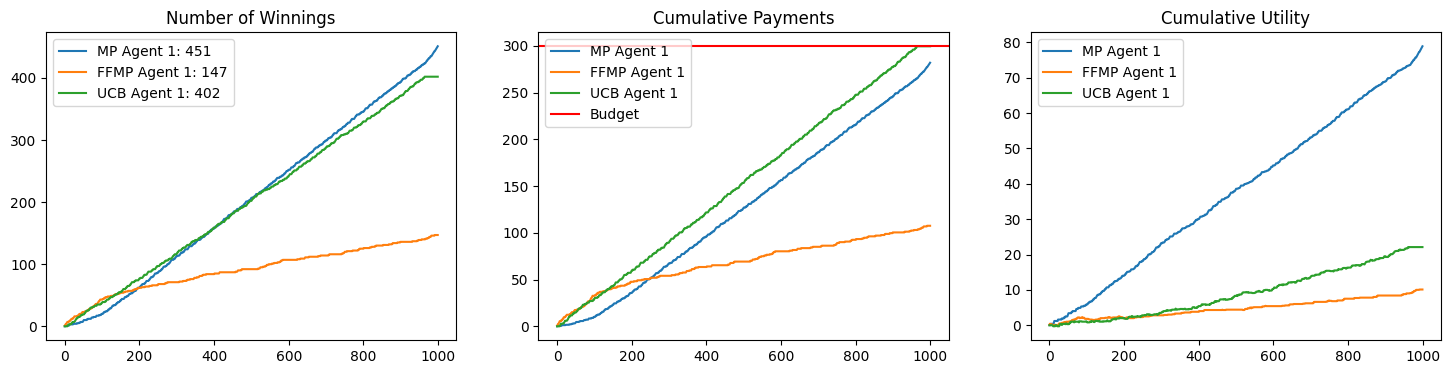

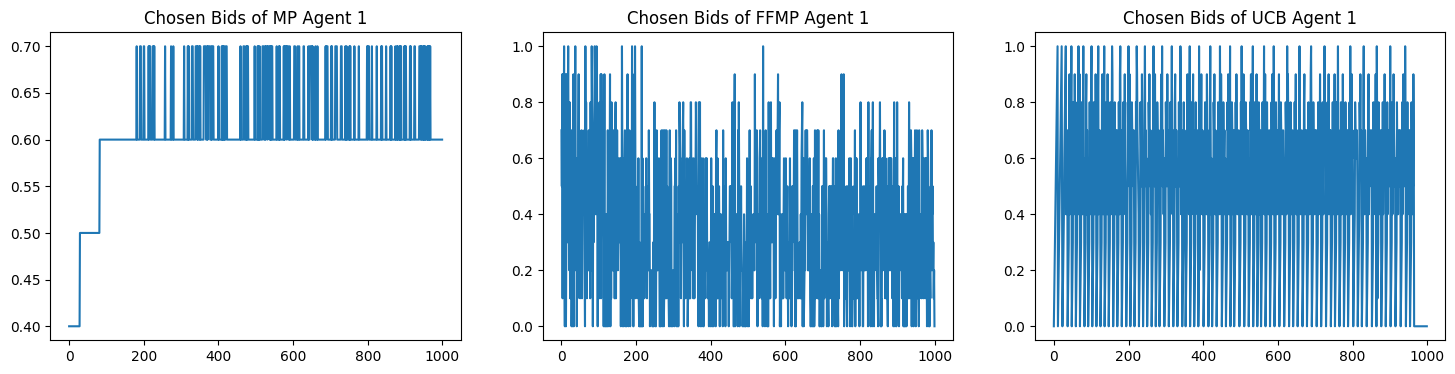

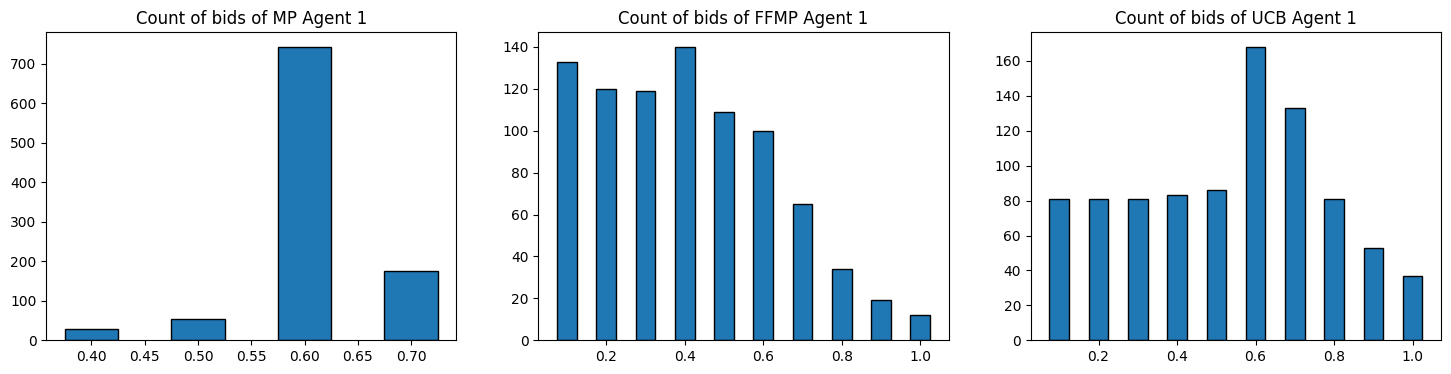

In [24]:
trial=Trial(n_users=1000)

## Increase number of arms (n_arms = 20)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   B = 300
*   n_users = 5000
*   **n_arms = 20**

Total # of interactions: 2119
Total # of Wins of player MP Agent 1: 1123
Total # of Wins of player FFMP Agent 1: 533
Total # of Wins of player UCB Agent 1: 464


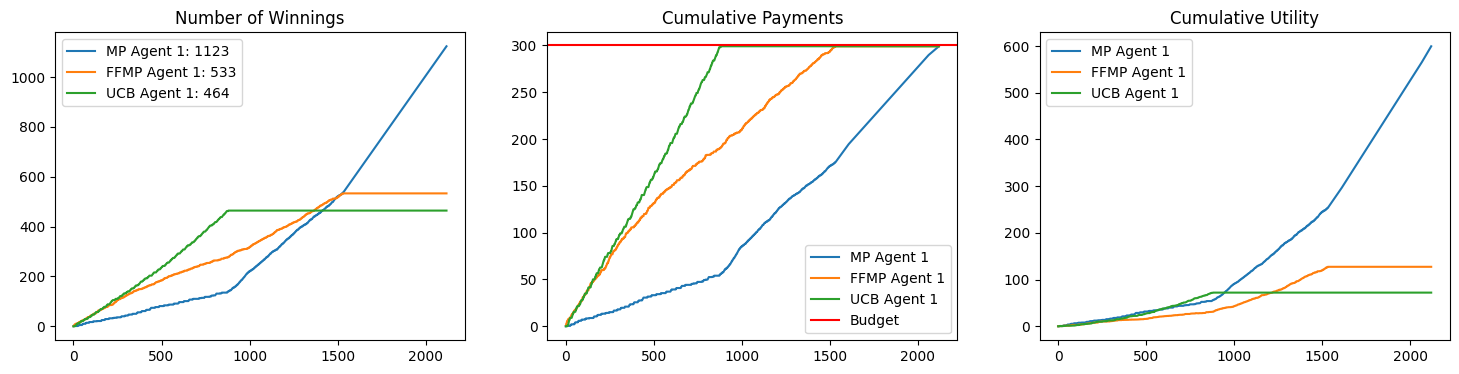

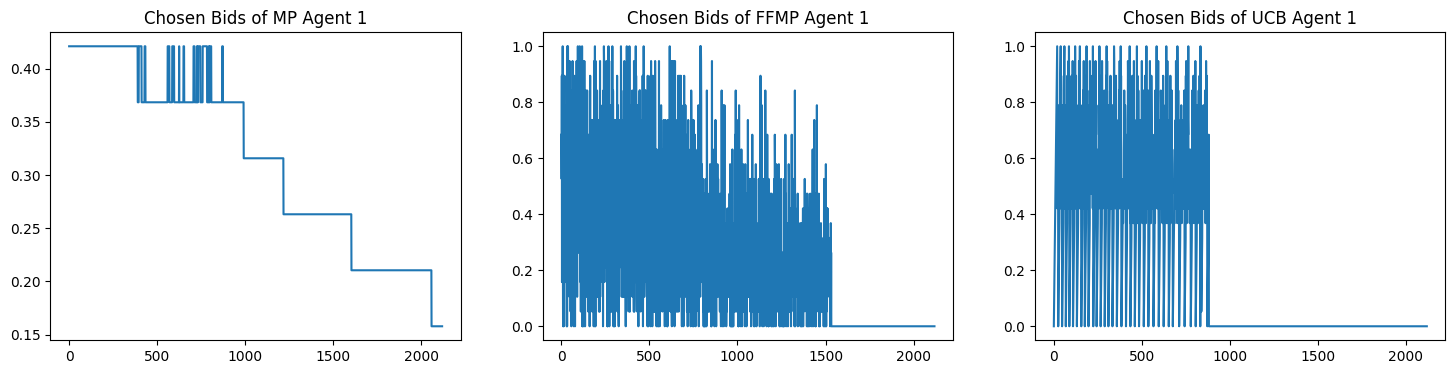

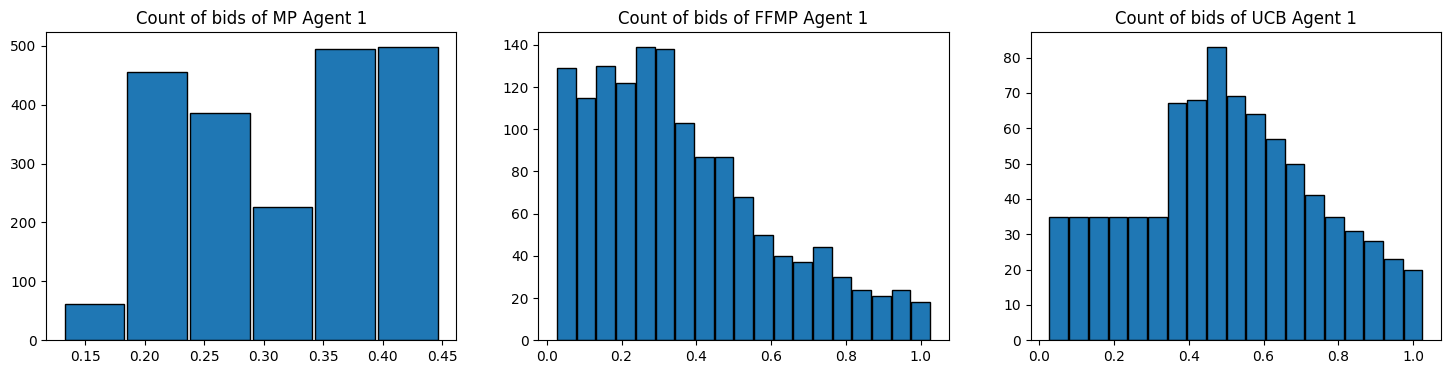

In [25]:
trial=Trial(n_arms=20)

## Decrease number of arms (n_arms = 5)

*   n_player_per_type = 1
*   my_evaluation = 0.8
*   B = 300
*   n_users = 5000
*   **n_arms = 5**

Total # of interactions: 2105
Total # of Wins of player MP Agent 1: 1071
Total # of Wins of player FFMP Agent 1: 519
Total # of Wins of player UCB Agent 1: 516


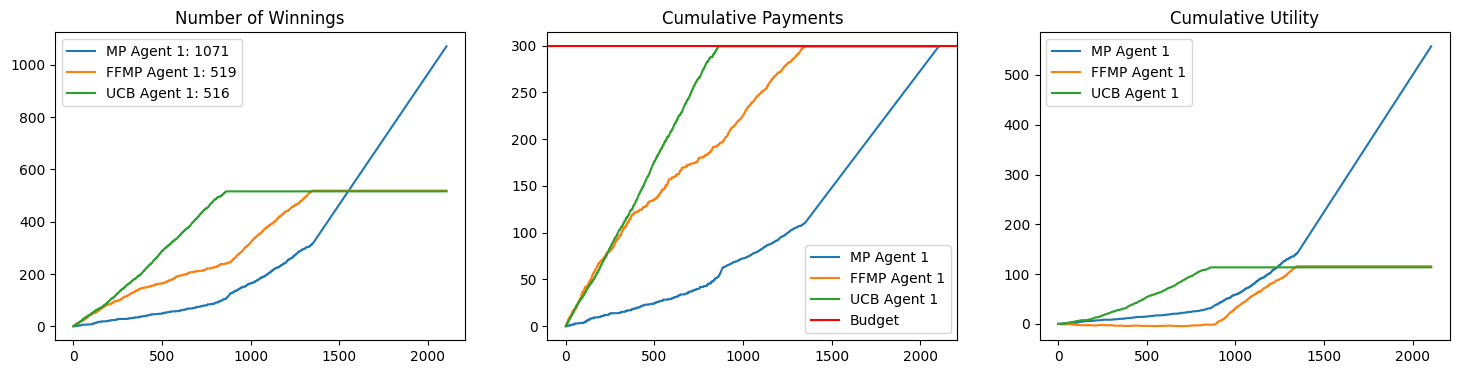

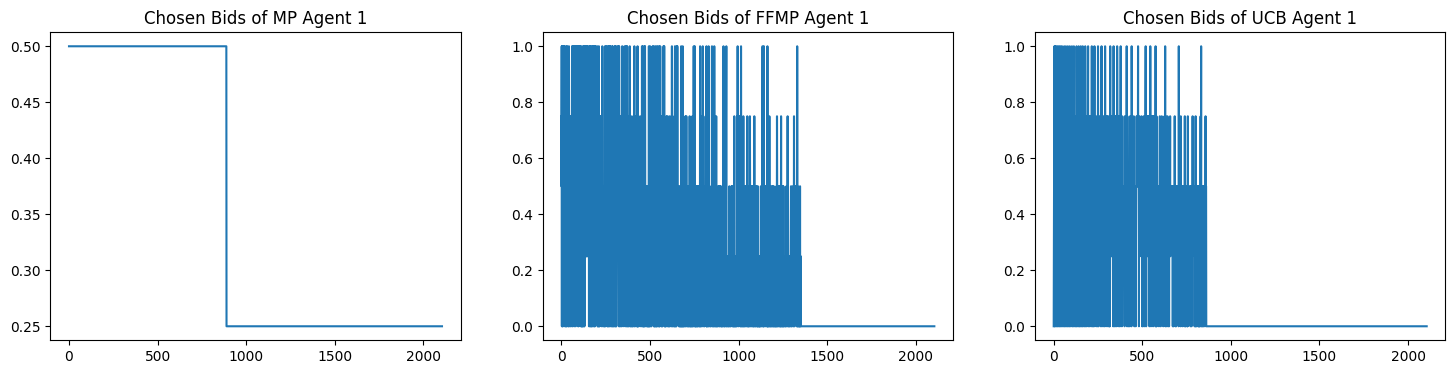

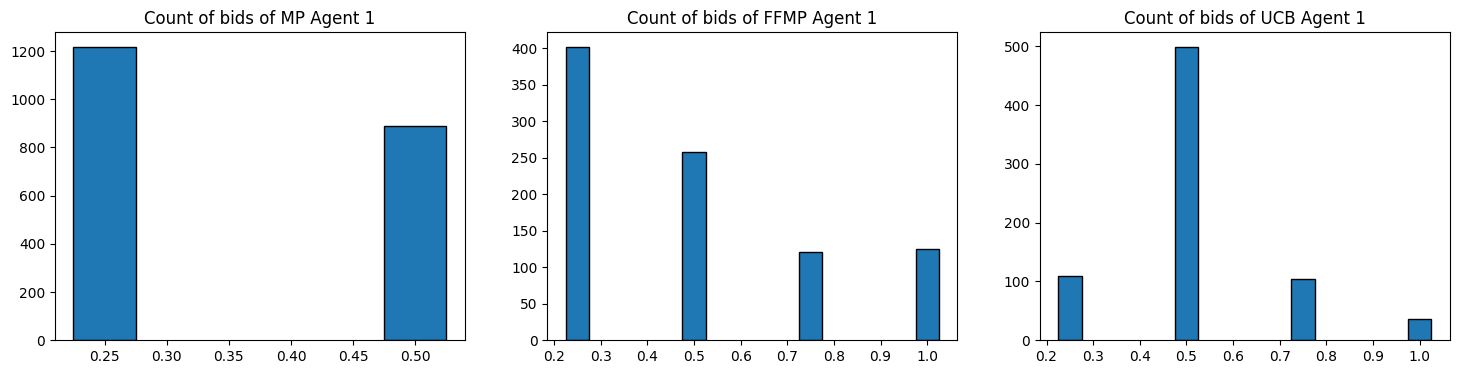

In [26]:
trial=Trial(n_arms=5)